In [6]:
%pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys; sys.path.append("../")
from feature_extractor import FeatureExtractor
import torch
import numpy as np
import time
from cascade import CascadeClassifier
import cv2
import joblib


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
parent = '../hFeatures6/'
data_path = 'new_data6'

# Features Extraction

In [4]:
mean = 111.02404842061983
std = 56.926623499738575

In [5]:
def transform1(img):
  return img
  # img = (img - img.mean()) / (img.std() + 1e-8)
  # return cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [6]:

feature_extractor = FeatureExtractor(shape=(24, 24),
                                     percentile=100,
                                     batch_size=1000,
                                     all_features_file=parent + "all_features.npz",
                                     selected_features_file=parent + "selected_features.npz",
                                     labels_file=parent + "labels.npy",
                                     indecies_file=parent + "indecies.npy",)

In [8]:

X, y = feature_extractor.extractFeatures(pos_path='../'+data_path+'/train/face',
                                  neg_path='../'+data_path+'/train/non-face',
                                  transform=transform1,
                                  save_to_file=False)
print('done')


all_features shape: (162336, 10854)
done


In [9]:
import gc
gc.collect()

317

In [27]:
# del feature_extractor.f2
# del feature_extractor.f3
# del feature_extractor.f4

In [14]:
# indecies, X = feature_extractor.selectPercentile(X, y )
# # y = np.load(parent + 'labels.npy')
# print(X.shape, y.shape)
# print('done')


Now selecting percentile features
(12792, 10854) (10854,)
done


In [30]:
# feature_extractor.f2, feature_extractor.f3, feature_extractor.f4 = feature_extractor.describe_features(feature_extractor.shape)

In [10]:
# temp = np.load('../hFeatures3/all_features.npz')['arr_0']
temp = X
temp

array([[ -53.,  -34., -113., ...,    0.,    1.,    0.],
       [  66.,   15.,   86., ...,    0.,    0.,    0.],
       [  -5.,  116., -144., ...,    0.,    1.,    0.],
       ...,
       [ -31.,   23., -167., ...,    0.,    7.,    0.],
       [  -4.,   -5.,  -72., ...,    0.,    2.,    0.],
       [   5.,   11.,  -34., ...,    0.,    2.,    0.]], dtype=float32)

In [11]:
print(temp.min())
print(temp.max())
print(temp[3])
print(temp[4])

-57652.0
51699.0
[  50. -177.   89. ...    0.    0.    0.]
[ -61. -184. -135. ...    0.   -3.    0.]


# Training

In [12]:
%rm StrongClassifier/lastSC.last
s_t = time.time()
cascadeClassifier= CascadeClassifier(X, y, batchsize=10000, verbose=True, layers=[200])
tr_acc = cascadeClassifier.train()

cascadeClassifier.save(parent + 'cascadeClassifier.pkl')

print('accuracy: ', tr_acc)
print('time taken: ', time.time() - s_t, 's')
print('done')

rm: cannot remove 'StrongClassifier/lastSC.last': No such file or directory
$$$$$$$ Training layer 1 / 1 $$$$$$$
Starting to choose classifier
Finished training weak classifier 1 / 200
Starting to choose classifier
Finished training weak classifier 2 / 200
Starting to choose classifier
Finished training weak classifier 3 / 200
Starting to choose classifier
Finished training weak classifier 4 / 200
Starting to choose classifier
Finished training weak classifier 5 / 200
Starting to choose classifier
Finished training weak classifier 6 / 200
Starting to choose classifier
Finished training weak classifier 7 / 200
Starting to choose classifier
Finished training weak classifier 8 / 200
Starting to choose classifier
Finished training weak classifier 9 / 200
Starting to choose classifier
Finished training weak classifier 10 / 200
Starting to choose classifier
Finished training weak classifier 11 / 200
Starting to choose classifier
Finished training weak classifier 12 / 200
Starting to choose c

In [13]:
cascadeClassifier.save_joblib(parent + 'cascadeClassifier.joblib')

In [14]:
joblib.dump(feature_extractor, parent + 'feature_extractor.joblib')

['../hFeatures6/feature_extractor.joblib']

In [18]:
# import pickle as pkl
# with open(parent + 'cascadeClassifier.pkl', 'rb') as f:
#   cascadeClassifier = pkl.load(f)

# Testing

In [15]:
# accuracy imports
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [16]:
s_t = time.time()
t_f_idx_map, t_features, t_labels = feature_extractor.extractFeaturesByIndecies(pos_path='../'+data_path+'/test/face',
                                            neg_path='../'+data_path+'/test/non-face',
                                            cascadeClassifier=cascadeClassifier,
                                            transform=transform1,
                                            use_percentile=False,)
print(t_features.shape, t_labels.shape)
predictions = cascadeClassifier.predict(t_features, t_f_idx_map)
print('test accuracy: ', np.sum(predictions == t_labels) / t_labels.shape[0])
print('time taken: ', time.time() - s_t, 's')

Now reading dataset...
Now extracting features from dataset...
(197, 2715) (2715,)
test accuracy:  0.9742173112338858
time taken:  72.12449145317078 s


In [17]:
# report
print('accuracy: ', accuracy_score(t_labels, predictions))
print('f1 score macro: ', f1_score(t_labels, predictions, average='macro'))
print('f1 score binary: ', f1_score(t_labels, predictions))
print('f1 score micro: ', f1_score(t_labels, predictions, average='micro'))
print('precision: ', precision_score(t_labels, predictions))
print('recall: ', recall_score(t_labels, predictions))
print('confusion matrix: \n', confusion_matrix(t_labels, predictions))
print('classification report: \n', classification_report(t_labels, predictions, digits=4))


accuracy:  0.9742173112338858
f1 score macro:  0.9711053580290159
f1 score binary:  0.9616228070175438
f1 score micro:  0.9742173112338858
precision:  0.9542981501632208
recall:  0.969060773480663
confusion matrix: 
 [[1768   42]
 [  28  877]]
classification report: 
               precision    recall  f1-score   support

           0     0.9844    0.9768    0.9806      1810
           1     0.9543    0.9691    0.9616       905

    accuracy                         0.9742      2715
   macro avg     0.9694    0.9729    0.9711      2715
weighted avg     0.9744    0.9742    0.9743      2715



# Try full image

In [22]:
# !mkdir /content/drive/MyDrive/GP/GP_try/hFeatures5_3
# !cp -r ../hFeatures5_3/* /content/drive/MyDrive/GP/GP_try/hFeatures5_3

mkdir: cannot create directory ‘/content/drive/MyDrive/GP/GP_try/hFeatures5_3’: File exists


In [23]:
# !mkdir ../../lfw_all
# !cp /content/drive/MyDrive/GP/lfw_all/* ../../lfw_all/

In [19]:
import random
from detect_face import FaceDetector
from PIL import Image
import os
import matplotlib.pyplot as plt
lfw_all = '../../lfw_all/'
all_images_names = os.listdir(lfw_all)
# all_images_names = sorted(all_images_names)
random.shuffle(all_images_names)
all_images_names = [lfw_all + name for name in all_images_names]
all_images_names[0]

'../../lfw_all/Crispin_Glover_0001.jpg'

In [20]:
show_images = list(range(0, 20))
rectangles_only = True
# resize_to = (100, 100)
random.shuffle(all_images_names)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
feature_extractor.verbose = False

In [24]:
from copy import deepcopy

In [25]:
cascadeClassifier2 = deepcopy(cascadeClassifier)
feature_extractor2 = deepcopy(feature_extractor)

In [26]:
faceDetector = FaceDetector(cascadeClassifier2, \
                            feature_extractor2,\

                            window_size=(24, 24),\
                            scale_dist=1.1,
                            max_size=300,
                            stride=5,

                            device=device,
                            use_percentile=False,
                            makeθ0=False,

                            verbose=False,
                            normalize_subwindows=False,
                            report_time=True,
                            use_sklearn=False
                            )

RGB
(250, 250)
{'Getting Subwindows': 0.04482579231262207, 'Resizing Subwindows': 0.10486054420471191, 'Normalize': 1.5020370483398438e-05, 'Extracting Features': 0.305560827255249, 'Classifying': 0.47472119331359863, 'total': 0.929983377456665}


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


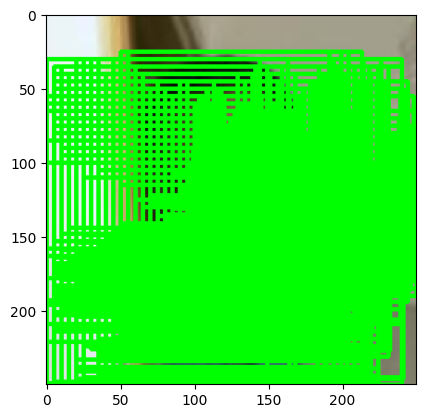

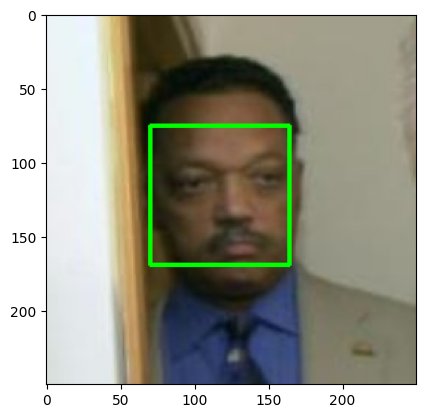

RGB
(250, 250)
{'Getting Subwindows': 0.05134701728820801, 'Resizing Subwindows': 0.07151412963867188, 'Normalize': 1.430511474609375e-05, 'Extracting Features': 0.25164008140563965, 'Classifying': 0.22889137268066406, 'total': 0.6034069061279297}


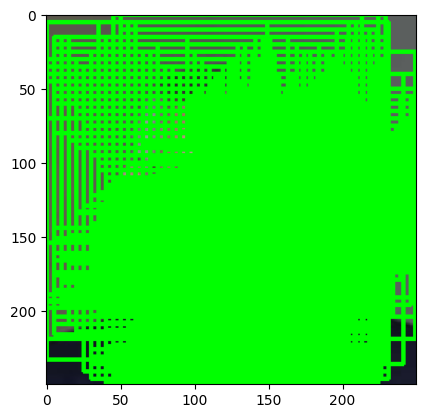

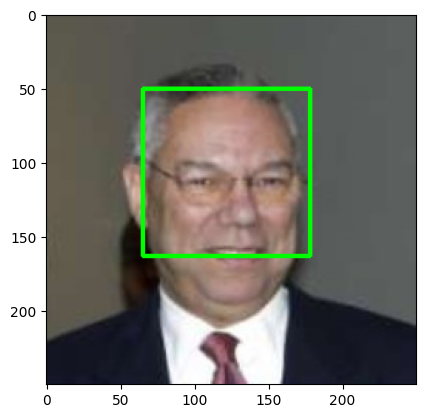

RGB
(250, 250)
{'Getting Subwindows': 0.044206857681274414, 'Resizing Subwindows': 0.07183575630187988, 'Normalize': 1.4543533325195312e-05, 'Extracting Features': 0.25024890899658203, 'Classifying': 0.2317209243774414, 'total': 0.5980269908905029}


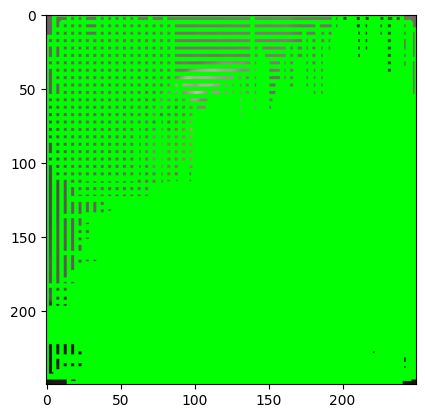

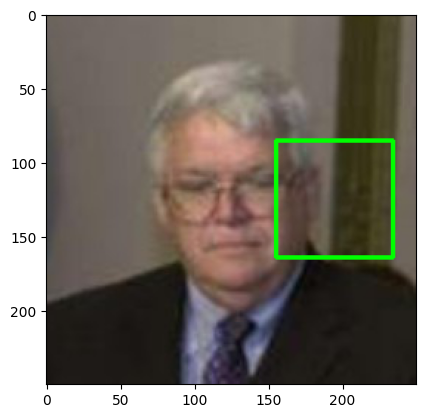

RGB
(250, 250)
{'Getting Subwindows': 0.04093742370605469, 'Resizing Subwindows': 0.07558226585388184, 'Normalize': 1.621246337890625e-05, 'Extracting Features': 0.2554514408111572, 'Classifying': 0.23074078559875488, 'total': 0.6027281284332275}


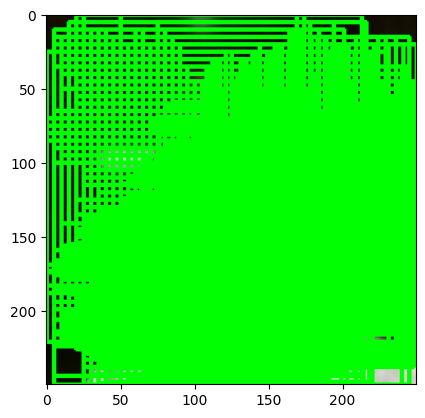

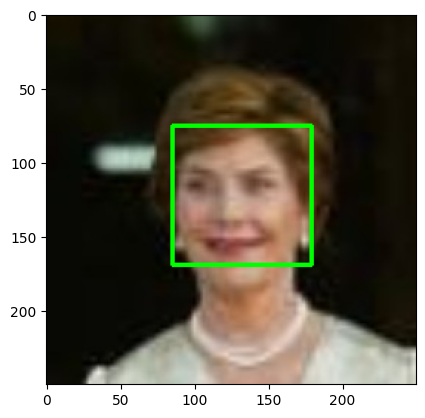

RGB
(250, 250)
{'Getting Subwindows': 0.04483175277709961, 'Resizing Subwindows': 0.07530808448791504, 'Normalize': 1.5020370483398438e-05, 'Extracting Features': 0.2585570812225342, 'Classifying': 0.23024630546569824, 'total': 0.6089582443237305}


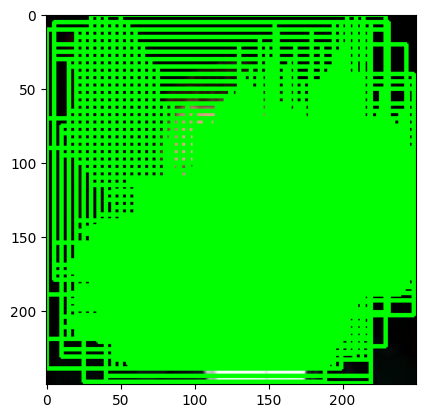

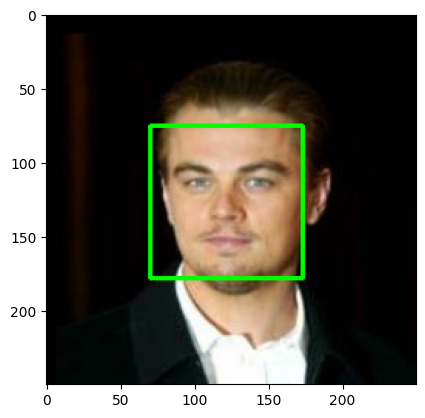

RGB
(250, 250)
{'Getting Subwindows': 0.05327749252319336, 'Resizing Subwindows': 0.07262420654296875, 'Normalize': 1.7642974853515625e-05, 'Extracting Features': 0.25377321243286133, 'Classifying': 0.2297830581665039, 'total': 0.6094756126403809}


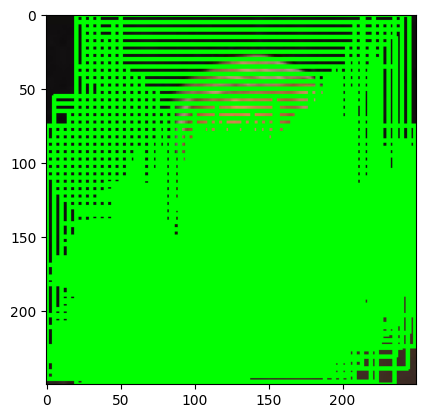

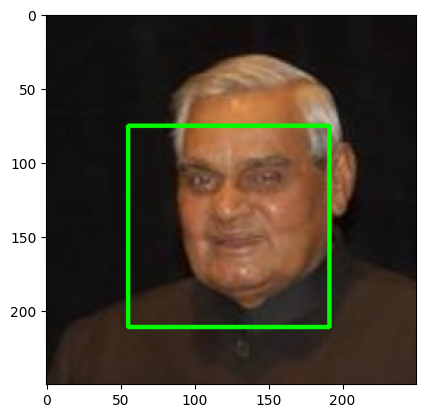

RGB
(250, 250)
{'Getting Subwindows': 0.04085350036621094, 'Resizing Subwindows': 0.07360625267028809, 'Normalize': 1.6689300537109375e-05, 'Extracting Features': 0.2622816562652588, 'Classifying': 0.23174452781677246, 'total': 0.6085026264190674}


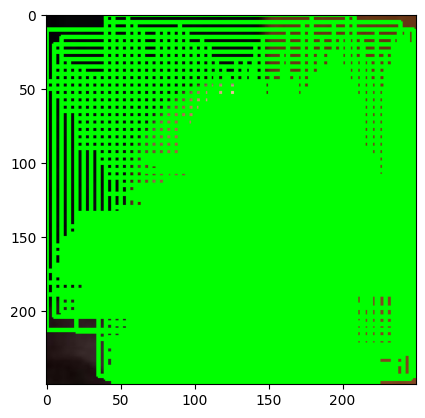

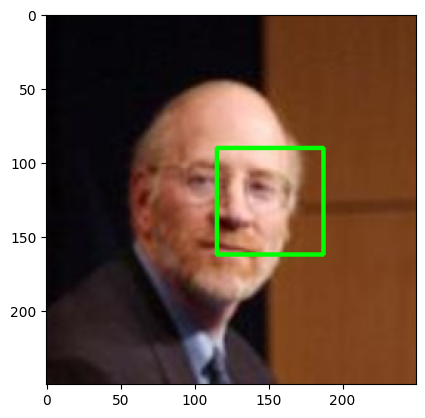

RGB
(250, 250)
{'Getting Subwindows': 0.043233633041381836, 'Resizing Subwindows': 0.07569551467895508, 'Normalize': 1.4781951904296875e-05, 'Extracting Features': 0.2611675262451172, 'Classifying': 0.23054218292236328, 'total': 0.6106536388397217}


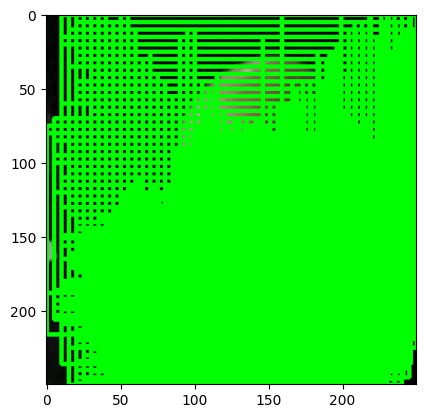

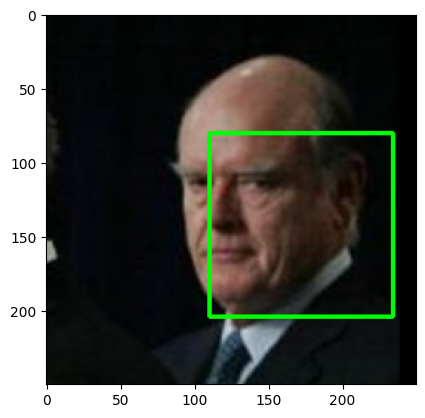

RGB
(250, 250)
{'Getting Subwindows': 0.043328046798706055, 'Resizing Subwindows': 0.07585763931274414, 'Normalize': 1.52587890625e-05, 'Extracting Features': 0.2541980743408203, 'Classifying': 0.227294921875, 'total': 0.600693941116333}


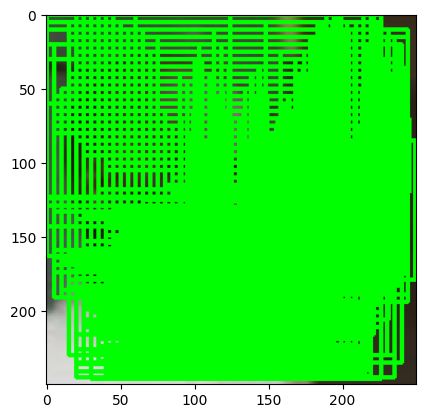

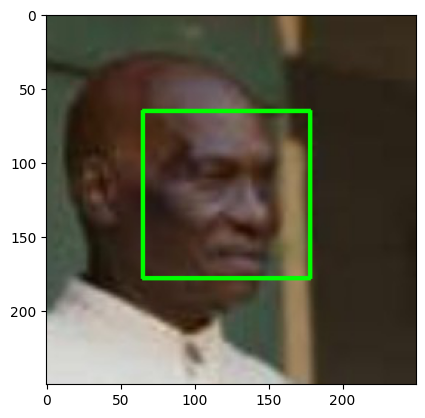

RGB
(250, 250)
{'Getting Subwindows': 0.042752742767333984, 'Resizing Subwindows': 0.07738304138183594, 'Normalize': 1.4543533325195312e-05, 'Extracting Features': 0.2613201141357422, 'Classifying': 0.2309093475341797, 'total': 0.612379789352417}


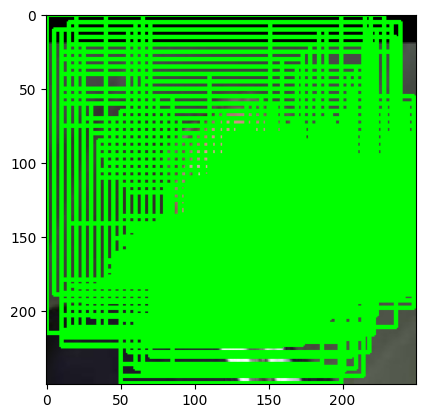

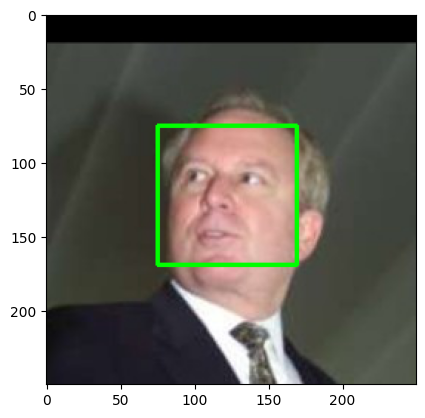

RGB
(250, 250)
{'Getting Subwindows': 0.04170417785644531, 'Resizing Subwindows': 0.0824432373046875, 'Normalize': 1.52587890625e-05, 'Extracting Features': 0.27186107635498047, 'Classifying': 0.264786958694458, 'total': 0.6608107089996338}


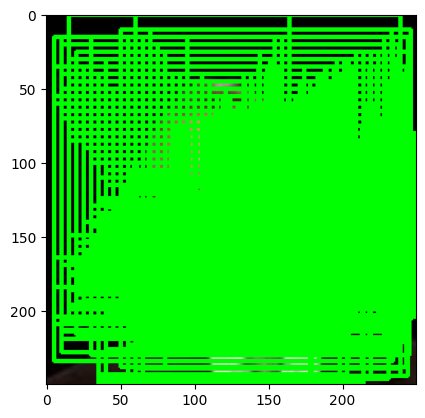

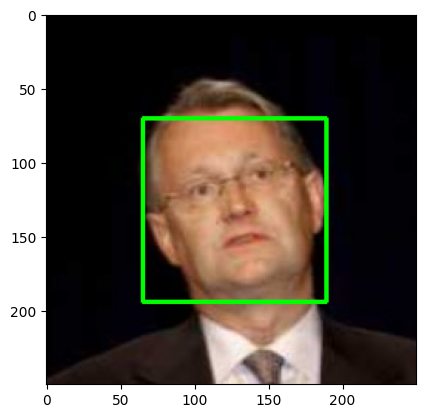

RGB
(250, 250)
{'Getting Subwindows': 0.04488492012023926, 'Resizing Subwindows': 0.07472753524780273, 'Normalize': 1.7642974853515625e-05, 'Extracting Features': 0.25656914710998535, 'Classifying': 0.23206520080566406, 'total': 0.6082644462585449}


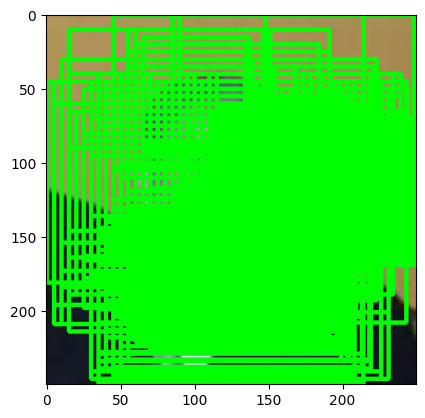

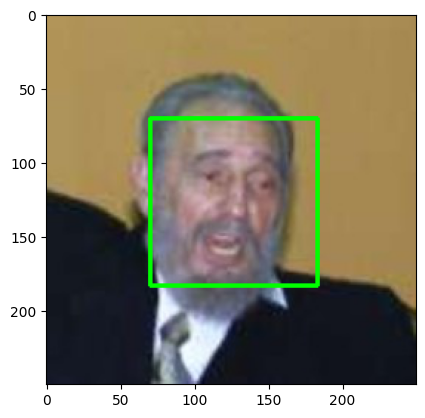

RGB
(250, 250)
{'Getting Subwindows': 0.04493546485900879, 'Resizing Subwindows': 0.07257962226867676, 'Normalize': 1.71661376953125e-05, 'Extracting Features': 0.27043604850769043, 'Classifying': 0.23582863807678223, 'total': 0.6237969398498535}


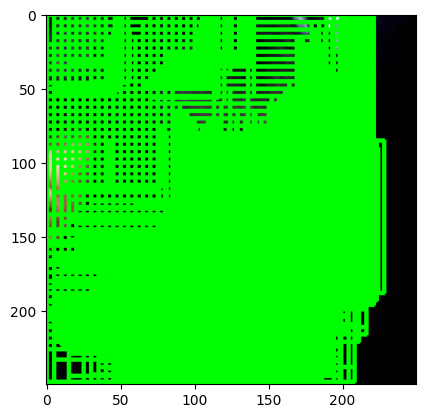

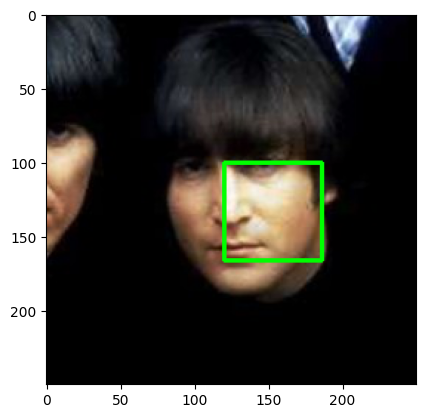

RGB
(250, 250)
{'Getting Subwindows': 0.04577493667602539, 'Resizing Subwindows': 0.0777285099029541, 'Normalize': 1.7404556274414062e-05, 'Extracting Features': 0.2594459056854248, 'Classifying': 0.251572847366333, 'total': 0.6345396041870117}


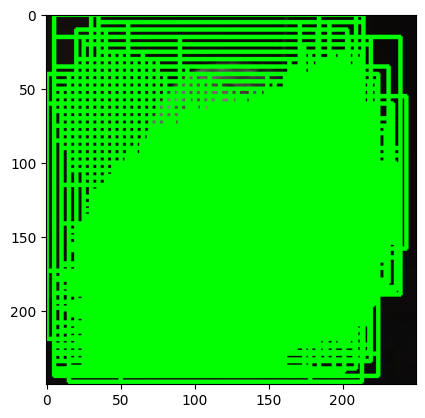

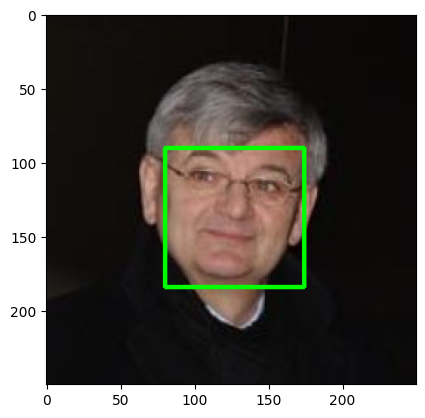

RGB
(250, 250)
{'Getting Subwindows': 0.04902219772338867, 'Resizing Subwindows': 0.0711069107055664, 'Normalize': 1.430511474609375e-05, 'Extracting Features': 0.2691824436187744, 'Classifying': 0.2575340270996094, 'total': 0.646859884262085}


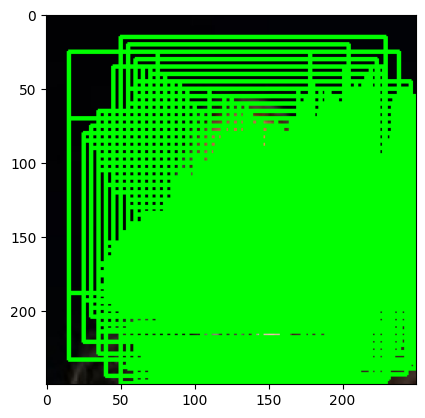

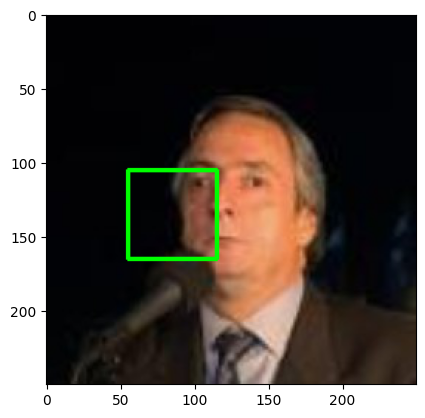

RGB
(250, 250)
{'Getting Subwindows': 0.04764080047607422, 'Resizing Subwindows': 0.06960797309875488, 'Normalize': 1.6450881958007812e-05, 'Extracting Features': 0.2708292007446289, 'Classifying': 0.2569847106933594, 'total': 0.6450791358947754}


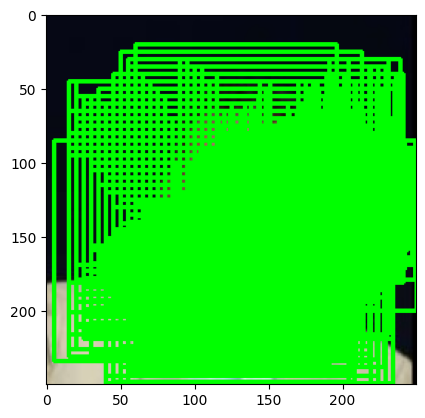

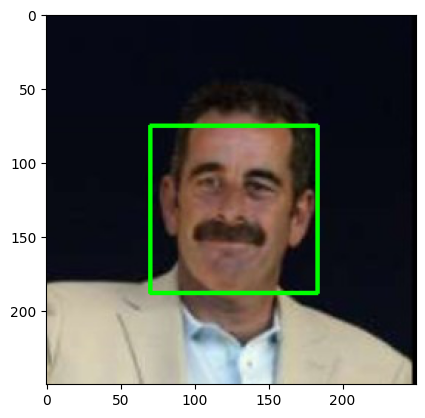

RGB
(250, 250)
{'Getting Subwindows': 0.05008578300476074, 'Resizing Subwindows': 0.07363343238830566, 'Normalize': 1.52587890625e-05, 'Extracting Features': 0.2646143436431885, 'Classifying': 0.24108552932739258, 'total': 0.62943434715271}


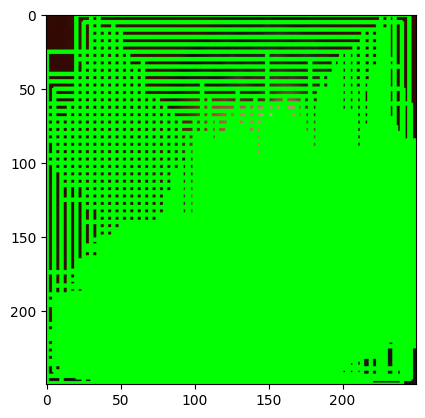

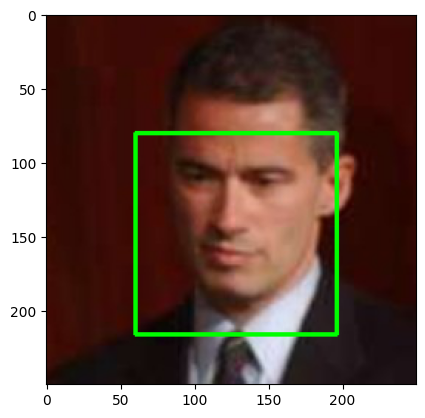

RGB
(250, 250)
{'Getting Subwindows': 0.046086788177490234, 'Resizing Subwindows': 0.07666468620300293, 'Normalize': 1.5497207641601562e-05, 'Extracting Features': 0.2515745162963867, 'Classifying': 0.23662042617797852, 'total': 0.6109619140625}


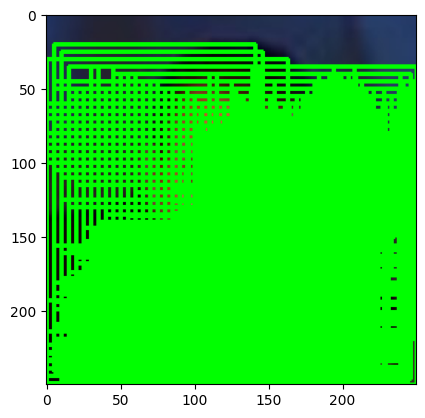

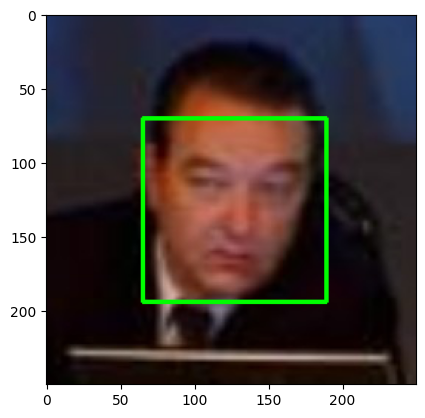

RGB
(250, 250)
{'Getting Subwindows': 0.04842376708984375, 'Resizing Subwindows': 0.07007288932800293, 'Normalize': 1.6689300537109375e-05, 'Extracting Features': 0.25476646423339844, 'Classifying': 0.22826743125915527, 'total': 0.6015472412109375}


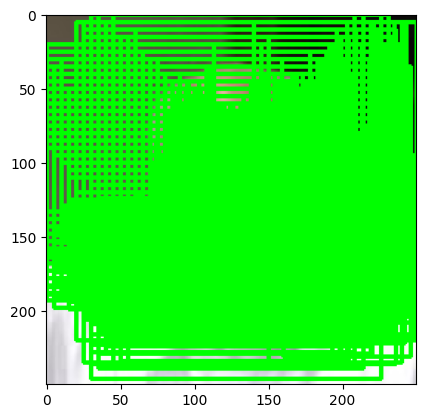

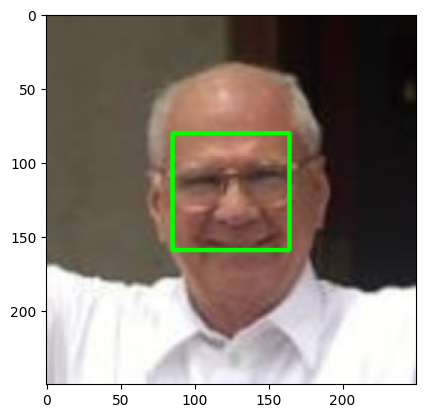

RGB
(250, 250)
{'Getting Subwindows': 0.04325556755065918, 'Resizing Subwindows': 0.07168722152709961, 'Normalize': 1.430511474609375e-05, 'Extracting Features': 0.2579684257507324, 'Classifying': 0.22603964805603027, 'total': 0.5989651679992676}


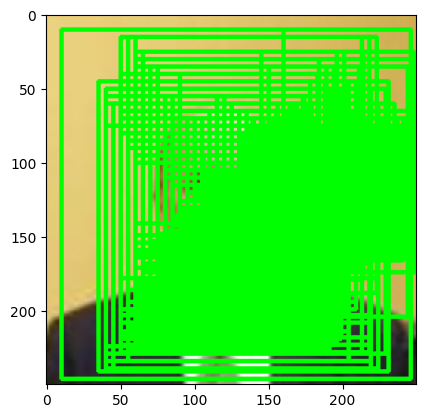

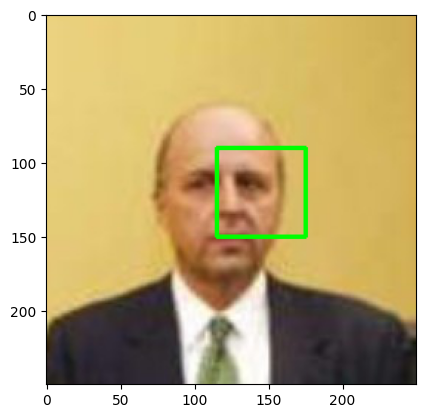

In [27]:
for i in show_images:
  # >>>> Read image <<<<
  img = Image.open(all_images_names[i])
  print(img.mode)
  img = np.array(img)
  org_sh = img.shape
  if not rectangles_only:
    plt.imshow(img)
    plt.show()
  # get subwindows
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img2.shape)

  # >>>> Normalize image <<<<
  # normalize image
  # img2 = (img2 - img2.mean()) / img2.std()
  # img2 = cv2.resize(img, resize_to)
  # print(img2.shape)

  # img2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # resize image
  # img2 = cv2.resize(img2, (570, 380))

  # show image
  if not rectangles_only:
    plt.imshow(img2, cmap='gray')
    plt.show()

  # +++++++++++++++++++++
  # find face
  # >>>> Find face <<<<
  face_coordinates, region_max_conf, max_conf , timing=\
                  faceDetector.find_face(img2, \
                                         predict=True,
                                         confidence=True)
  print(timing)
  # region_max_conf *= img.shape[0] / resize_to[0]
  # ++++++++++++++++++++
  # rectangles
  # >>>> Draw rectangles <<<<
  tmp_img = img.copy()
  for face_coordinate in face_coordinates:
      for x1, y1, x2, y2 in face_coordinate:
          cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  # if not rectangles_only:
  plt.imshow(tmp_img)
  plt.show()

  # >>>> Draw rectangles with max confidence <<<<
  # amx confidence
  tmp_img = img.copy()
  x1, y1, x2, y2 = region_max_conf
  cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  plt.imshow(tmp_img)
  plt.show()



In [29]:
tmpX = faceDetector.classifier.X
faceDetector.classifier.X = None
joblib.dump(faceDetector, parent + 'faceDetector.joblib')
faceDetector.classifier.X = tmpX